In [1]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 44.2 MB/s eta 0:00:00


In [2]:
!pip install rank_bm25

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from glob import glob
import json
from underthesea import sent_tokenize
import re
from rank_bm25 import BM25Okapi
import collections

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
class Visualization():
  def __init__(self,
               data_path):
    self.data_paths = glob(data_path + '/*/*.json')
    self.raw_data = self.read_files(self.data_paths)
    self.raw_data = pd.DataFrame(self.raw_data)
    self.bm25 = BM25Okapi([txt.split() for txt in self.raw_data['context']])
    raw_context = self.raw_data['context'].map(self.split_doc)
    self.raw_context = []
    for i in range(len(raw_context)):
      self.raw_context.extend(raw_context[i])
    self.raw_context = pd.Series(self.raw_context)

  def read_files(self, paths):
        results = list(map(self.read_file, paths))
        return results

  @staticmethod
  def read_file(file):
    with open(file, 'r') as f:
      data = json.load(f)
    return data

  @staticmethod
  def split_doc(graphs):
    output = sent_tokenize(graphs)
    in_element = list(map(lambda x:x[:-1].strip(), output[:-1]))
    last_element = output[-1] if (output[-1][-1] != '.') else output[-1][-1].strip()
    return in_element + [last_element]

  def num_of_sentences(self):
    context = list(self.raw_data['context'])
    nos = [len(sent_tokenize(x)) for x in context]
    plt.hist(nos, bins=list(range(max(nos) + 1)))
    plt.show()
    print("Số câu trung bình của các đoạn context:", np.mean(nos))

  def num_of_words_claims(self):
    claim = list(self.raw_data['claim'])
    claim = [len(x.split()) for x in claim]
    plt.hist(claim, bins=list(range(max(claim) + 1)))
    plt.show()
    print("Số từ trung bình trong 1 claim:", np.mean(claim))

  def num_of_words_evidient(self):
    evidient = list(self.raw_data['evidient'])
    evidient = [len(x.split()) for x in evidient]
    plt.hist(evidient, bins=list(range(max(evidient) + 1)))
    plt.show()
    print("Số từ trung bình trong 1 evidient:", np.mean(evidient))

  def label(self):
    return self.raw_data['verdict'].value_counts(0)

  def bm25_retrieval(self, text, top_k):
    doc_scores = np.array(self.bm25.get_scores(text.split()))
    sort_idx = np.flip(np.argsort(doc_scores))
    return [self.raw_context[idx] for idx in sort_idx[:top_k]]

  def bm25_result(self, top_k):
    correct = 0
    wrong = 0
    for i in range(len(self.raw_data['claim'])):
      fact_list = self.bm25_retrieval(self.raw_data['claim'][i], top_k)
      if self.raw_data['evidient'][i] in fact_list:
        correct += 1
      else:
        wrong += 1
    accuracy = correct / (correct + wrong)
    result = pd.DataFrame({"Labels": ["Correct", "Wrong"], "Values": [correct, wrong]})
    result.plot.bar(x="Labels", y="Values")
    print("Độ chính xác khi dùng bm25 là:", accuracy * 100, "%")



In [30]:
a = Visualization("/content/gdrive/MyDrive/Test/train")

Độ chính xác khi dùng bm25 là: 72.63636363636363 %


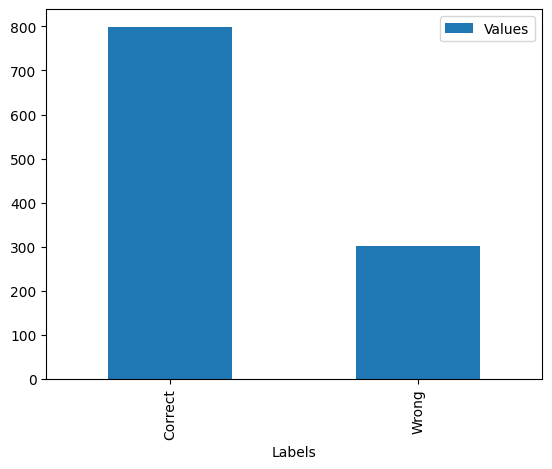

In [31]:
a.bm25_result(10)